# Robot Control Interface

This notebook provides a ROS robot control interface (action client) with features:
- Set a goal position (x, y)
- Cancel the current goal
- Real-time display of the robot’s current position
- Display the distance to the closest obstacle

In [1]:
# Import required libraries
import rospy
import actionlib
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, clear_output
import ipywidgets as widgets
from nav_msgs.msg import Odometry
from sensor_msgs.msg import LaserScan
from geometry_msgs.msg import Point, Twist
from assignment2_part1_rt.msg import PlanningAction, PlanningGoal, Status
from std_srvs.srv import SetBool
from assignment2_part1_rt.srv import DisAvg
from actionlib_msgs.msg import GoalStatus
import math
import time

In [2]:
# Initialize ROS node
if not rospy.core.is_initialized():
    rospy.init_node('robot_control_interface', anonymous=True)
    print("ROS node initialized: robot_control_interface")
else:
    print("ROS node already initialized")

ROS node initialized: robot_control_interface


## Global Variables and State Tracking

In [3]:
# Define global variables
robot_position = {'x': 0.0, 'y': 0.0}
robot_velocity = {'linear_x': 0.0, 'angular_z': 0.0}
target_position = {'x': 0.0, 'y': 0.0}
closest_obstacle = 10.0  # default max detection range
regions = None  # laser scan regions
goal_active = False  # whether a goal is active

# Path history
position_history = {'x': [], 'y': []}
max_history_points = 100  # max history length

## Callback Functions

In [4]:
# Odometry callback function
def odom_callback(msg):
    """Process odometry to update position and velocity."""
    global robot_position, robot_velocity, position_history
    
    # Update position
    robot_position['x'] = msg.pose.pose.position.x
    robot_position['y'] = msg.pose.pose.position.y
    
    # Update velocity
    robot_velocity['linear_x'] = msg.twist.twist.linear.x
    robot_velocity['angular_z'] = msg.twist.twist.angular.z
    
    # Update position history
    position_history['x'].append(robot_position['x'])
    position_history['y'].append(robot_position['y'])
    
    # Limit history size
    if len(position_history['x']) > max_history_points:
        position_history['x'].pop(0)
        position_history['y'].pop(0)

In [5]:
# Laser scan callback function
def laser_callback(msg):
    """Process laser scan to find the closest obstacle."""
    global closest_obstacle, regions
    
    # Get minimum distance from laser scan data
    ranges = list(filter(lambda x: not math.isinf(x), msg.ranges))
    if ranges:
        closest_obstacle = min(ranges)
    else:
        closest_obstacle = 10.0  # default value
        
    # Calculate distances for each region
    regions = {
        'right': min(min(msg.ranges[0:143]), 10),
        'fright': min(min(msg.ranges[144:287]), 10),
        'front': min(min(msg.ranges[288:431]), 10),
        'fleft': min(min(msg.ranges[432:575]), 10),
        'left': min(min(msg.ranges[576:719]), 10),
    }

## Action Client Setup

In [6]:
# Initialize action client
client = actionlib.SimpleActionClient('/reaching_goal', PlanningAction)
print("Connecting to action server...")
client_connected = client.wait_for_server(timeout=rospy.Duration(5.0))

if client_connected:
    print("Connected to action server")
else:
    print("Failed to connect to action server. Please check ROS setup.")

Connecting to action server...
Connected to action server


In [7]:
# Set up subscribers
odom_sub = rospy.Subscriber('/odom', Odometry, odom_callback)
laser_sub = rospy.Subscriber('/scan', LaserScan, laser_callback)
status_pub = rospy.Publisher('/status', Status, queue_size=1)

# Set up services
try:
    rospy.wait_for_service('dist_avg', timeout=2.0)
    dist_avg_service = rospy.ServiceProxy('dist_avg', DisAvg)
    print("Connected to distance average service")
except rospy.ROSException:
    print("Failed to connect to distance average service")
    dist_avg_service = None

Connected to distance average service


## Utility Functions

In [8]:
# Publish robot status function
def publish_robot_status():
    """Publish the current robot status to the status topic"""
    status = Status()
    status.x = robot_position['x']
    status.y = robot_position['y']
    status.v_x = robot_velocity['linear_x']
    status.v_z = robot_velocity['angular_z']
    status_pub.publish(status)

# Check if goal reached
def goal_reached():
    """Check if the goal has been reached"""
    return client.get_state() == GoalStatus.SUCCEEDED

# Set goal function
def set_goal(x, y):
    """Set a new goal position"""
    global target_position, goal_active
    
    # Update coordinates
    target_position['x'] = x
    target_position['y'] = y
    
    # Update ROS parameters
    rospy.set_param("des_pos_x", x)
    rospy.set_param("des_pos_y", y)
    
    # Create and send goal
    goal = PlanningGoal()
    goal.target_pose.pose.position.x = x
    goal.target_pose.pose.position.y = y
    
    client.send_goal(goal)
    goal_active = True
    
    print(f"Goal set: x={x}, y={y}")
    return True

# Cancel goal function
def cancel_goal():
    """Cancel the current goal"""
    global goal_active
    
    if goal_reached():
        print("Goal just reached. Cannot cancel.")
        return False
    
    client.cancel_goal()
    goal_active = False
    print("Goal canceled")
    return True

## Interactive UI Components

In [9]:
# Goal setting widgets
x_slider = widgets.FloatSlider(
    value=0.0,
    min=-10.0,
    max=10.0,
    step=0.1,
    description='X:',
    continuous_update=False
)

y_slider = widgets.FloatSlider(
    value=0.0,
    min=-10.0,
    max=10.0,
    step=0.1,
    description='Y:',
    continuous_update=False
)

set_goal_button = widgets.Button(
    description='Set Goal',
    button_style='success',
    tooltip='Click to set a new goal',
    icon='check'
)

cancel_goal_button = widgets.Button(
    description='Cancel Goal',
    button_style='danger',
    tooltip='Click to cancel the current goal',
    icon='stop'
)

# Status display widget
robot_status = widgets.HTML(
    value='<h3>Robot Status</h3>',
    placeholder='Robot status will be displayed here',
    description='',
)

# Button event handlers
def on_set_goal_button_clicked(b):
    set_goal(x_slider.value, y_slider.value)
    update_display()

def on_cancel_goal_button_clicked(b):
    cancel_goal()
    update_display()

# Register event handlers
set_goal_button.on_click(on_set_goal_button_clicked)
cancel_goal_button.on_click(on_cancel_goal_button_clicked)

## Visualization Functions

In [10]:
# Visualize robot and environment
def visualize_robot():
    """Visualize the robot's position, path history, and goal"""
    plt.figure(figsize=(10, 8))
    
    # Set grid and axes
    plt.grid(True)
    plt.xlim(-12, 12)
    plt.ylim(-12, 12)
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.title('Robot Position and Goal')
    
    # Draw path history
    if position_history['x'] and position_history['y']:
        plt.plot(position_history['x'], position_history['y'], 'b-', alpha=0.5, label='Path History')
    
    # Draw goal position
    plt.plot(target_position['x'], target_position['y'], 'r*', markersize=15, label='Goal')
    
    # Draw current robot position
    plt.plot(robot_position['x'], robot_position['y'], 'go', markersize=10, label='Robot')
    
    # Draw laser scan data (if available)
    if regions:
        # Simple obstacle display
        angles = ['right', 'fright', 'front', 'fleft', 'left']
        angle_values = [0, 45, 90, 135, 180]
        
        for i, region in enumerate(angles):
            if regions[region] < 10.0:  # Display only if within max range
                angle_rad = math.radians(angle_values[i])
                obst_x = robot_position['x'] + regions[region] * math.cos(angle_rad)
                obst_y = robot_position['y'] + regions[region] * math.sin(angle_rad)
                plt.plot([robot_position['x'], obst_x], [robot_position['y'], obst_y], 'r-', alpha=0.3)
                plt.plot(obst_x, obst_y, 'rx', markersize=8)
    
    plt.legend()
    plt.show()

# Update status display
def update_status_display():
    """Update the robot status display"""
    global robot_status
    
    # Get distance to goal
    distance_to_goal = math.sqrt((target_position['x'] - robot_position['x'])**2 + 
                                (target_position['y'] - robot_position['y'])**2)
    
    # Construct status HTML
    status_html = f"""
    <h3>Robot Status</h3>
    <table style="width:100%">
      <tr>
        <td><b>Current Position:</b></td>
        <td>X: {robot_position['x']:.2f}, Y: {robot_position['y']:.2f}</td>
      </tr>
      <tr>
        <td><b>Goal Position:</b></td>
        <td>X: {target_position['x']:.2f}, Y: {target_position['y']:.2f}</td>
      </tr>
      <tr>
        <td><b>Distance to Goal:</b></td>
        <td>{distance_to_goal:.2f} m</td>
      </tr>
      <tr>
        <td><b>Closest Obstacle:</b></td>
        <td>{closest_obstacle:.2f} m</td>
      </tr>
      <tr>
        <td><b>Linear Velocity:</b></td>
        <td>{robot_velocity['linear_x']:.2f} m/s</td>
      </tr>
      <tr>
        <td><b>Angular Velocity:</b></td>
        <td>{robot_velocity['angular_z']:.2f} rad/s</td>
      </tr>
      <tr>
        <td><b>Goal Status:</b></td>
        <td>{"Active" if goal_active else "Inactive"}</td>
      </tr>
    </table>
    """
    
    robot_status.value = status_html
    
    # Publish robot status to topic
    publish_robot_status()

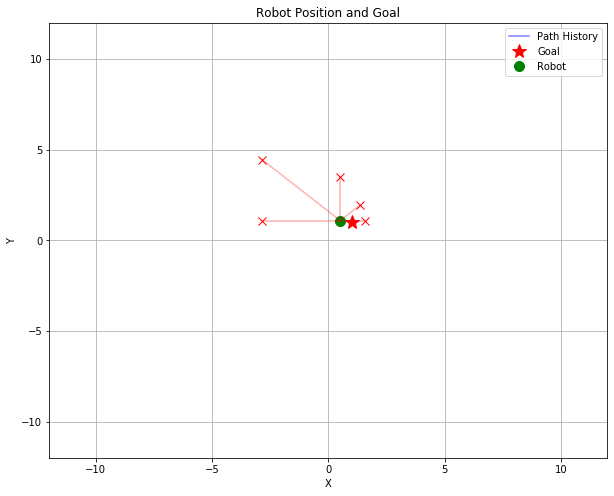

In [12]:
# Update the display
def update_display():
    """Update the entire interface display"""
    clear_output(wait=True)
    update_status_display()
    
    # Display the control panel
    controls = widgets.VBox([
        widgets.HBox([x_slider, y_slider]),
        widgets.HBox([set_goal_button, cancel_goal_button]),
        robot_status
    ])
    
    display(controls)
    visualize_robot()

# Initial display
update_display()

## Auto Update Feature

In [13]:
# Code for automatic display update
import threading
import time

def auto_update_display():
    """Automatically refreshes the display at regular intervals"""
    try:
        while True:
            update_display()
            time.sleep(1)
    except Exception as e:
        print(f"Automatic update has ended: {e}")

# Start of the auto update thread
update_thread = threading.Thread(target=auto_update_display)
update_thread.daemon = True
update_thread.start()

## Clean up

Run this cell before closing the notebook to clean up resources.

In [13]:
# Cleaning up subscribers and publishers
def cleanup():
    """Clean up your resources and unsubscribe"""
    odom_sub.unregister()
    laser_sub.unregister()
    status_pub.unregister()
    print("Cleanup completed, all subscriptions have been unsubscribed.")

# Clean up
cleanup()